# CAN Intrusion Analysis using Neural Networks

## Data set
As modern vehicles have lots of connectivity, protecting in-vehicle network from cyber-attacks is an important issue. Controller Area Network (CAN) is the standard protocol for the in-vehicle network. But, the lack of security features in the CAN protocol makes vehicles vulnerable to attacks. The message injection attack is a representative attack type which injects fabricated messages to deceive electronic control unit (ECUs) or cause malfunctions. Through this notebook, you will develop ML modeles to detect different types of CAN attacks and protect vehicle networks.

### Source
The dataset (CAN-intrusion-dataset-10000.csv) has been constructed by logging CAN traffic via the OBD-II port from a real vehicle while message injection attacks were performing. The classification goal is to distinguish cyber-attacks and normal samples by classifying the data samples. The dataset includes over 10,000 records and 10 attributes (including the target variable "Label").

### Variables
The definitions of the attributes are as followss.

* CAN ID : identifier of CAN message.
* DATA[0~7] : data value (byte), ranging from 0 to 255. They have been converted from hexadecimal numbers to decimal numbers.  
* Label : 0 indicates 'Normal', and 1 indicates an attack (including DoS, Fuzzy, Gear, or RPM).

In [ ]:

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler

!pip install scikeras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import SGD #Stochastic Gradient Descent optimizer
from tensorflow.keras.layers import Dense, Input
import tensorflow as tf

import time

#add other imports here if any (for example, pytorch)

## Question 1: Load Datasets (15pts)
A) Load the Dataset CAN-intrusion-dataset-10000.csv

B) Split the data into equals-sized training and test sets (use a random_state = 1, and do not shuffle the data).  

C) How many observations do you have in your training set?  

D) How many observations for each class in your training set?

E) Z-standarize the input features of the training and test sets.

In [ ]:
### Loading the Dataset

df = pd.read_csv('CAN-intrusion-dataset-10000.csv')
df.head()

,CAN_ID,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,Label
0,305,0,128,0,0,85,127,4,167,0
1,339,0,33,16,255,0,255,0,0,0
2,704,20,0,0,0,0,0,0,0,0
3,339,0,33,16,255,0,255,0,0,0
4,1072,0,0,0,0,0,0,0,0,0


In [ ]:
### Splitting the data into equals-sized training and test sets (use a random_state = 1 for reproducibility)

X = df.drop(columns=["Label"])
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, shuffle=False)

In [ ]:
### Confirming observations in training set

print(f"Number of observations: {len(X_train)}")

Number of observations: 5000


In [ ]:
### Confirming observations in test set

class_counts = y_train.value_counts()
print("Class distribution in the training set:")
print(class_counts) #Label 0 means how many were not cyberattacks, Label 1 means how many were cyberattacks

Class distribution in the training set:
Label
0    4284
1     716
Name: count, dtype: int64


In [ ]:
### Z-standarizing the input features of the training and test sets

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Standardization applied. Sample of scaled training set:")
print(X_train_scaled.head()) #Visualizing standardized data

Standardization applied. Sample of scaled training set:
     CAN_ID    DATA_0    DATA_1    DATA_2    DATA_3    DATA_4    DATA_5  \
0 -1.002660 -0.650510  1.537016 -0.692353 -0.778331  0.447407  0.833771   
1 -0.915157 -0.650510 -0.228059 -0.418910  1.699335 -0.708690  2.476847   
2  0.024215 -0.425235 -0.841190 -0.692353 -0.778331 -0.708690 -0.796468   
3 -0.915157 -0.650510 -0.228059 -0.418910  1.699335 -0.708690  2.476847   
4  0.971307 -0.650510 -0.841190 -0.692353 -0.778331 -0.708690 -0.796468   

     DATA_6    DATA_7  
0 -0.386935  1.369994  
1 -0.457245 -0.683712  
2 -0.457245 -0.683712  
3 -0.457245 -0.683712  
4 -0.457245 -0.683712  


In [ ]:
### L1-regularized logistic regression model

start_time = time.time()

model = LogisticRegression(penalty='l1', solver='liblinear', random_state=1)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

end_time = time.time()

In [ ]:
### Key metrics

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Precision: 0.98
Recall: 0.56
F1-Score: 0.71


In [ ]:
### model execution time

execution_time = (end_time - start_time) * 1000
print(f"Model execution time: {execution_time:.2f} ms")

Model execution time: 26.53 ms


## Question 3: Single Layer Neural Networks (30 pts)
In this task we aim to build models with better performance, using "deep" learning. __You may use PyTorch or Keras libraries for building deep learning models.__

A) Implement a single-layer neural network model that is used to classify the CAN intrusion data samples into normal and anomalous classes (0: normal, 1: attack). Use the standarized training set from Q1E) to train the network.

The details of the model are as follows:
* Use a Sigmoid as the output layer acitivation function to enable non-linearity.
* Use the binary cross-entropy loss as a training criterion.
* Use Stochastic gradient descent optimizer with a learning rate of 0.1.
* Run the model for 10 iterations/epochs.

B) Record the loss for each iteration, and make a plot of iterations/epochs vs loss(Binary Cross Entropy).

C) Print out the precision, recall, and F1-score of the test set.

D) Print out the model execution time (including both training and testing time) in milliseconds. Please keep two decimal places.

In [ ]:
### Single-layer NN model to classify CAN intrusion data samples into normal and anomalous classes (0:normal,1:attack)
# Model details:
# Sigmoid as the output layer acitivation function to enable non-linearity.
# binary cross-entropy loss as a training criterion.
# Stochastic gradient descent optimizer with a learning rate of 0.1.
# 10 iterations/epochs.

start_time = time.time()

model = Sequential([
    Dense(1, activation='sigmoid', input_shape=(X_train_scaled.shape[1],))
])

model.compile(optimizer=SGD(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=1)

end_time = time.time()

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7810 - loss: 0.5140
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9024 - loss: 0.3072
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9186 - loss: 0.3010
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9353 - loss: 0.2934
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9386 - loss: 0.2757
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9369 - loss: 0.2831
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9333 - loss: 0.2869
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9407 - loss: 0.2643
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9378 - loss: 0.2807
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9317 - loss: 0.2807


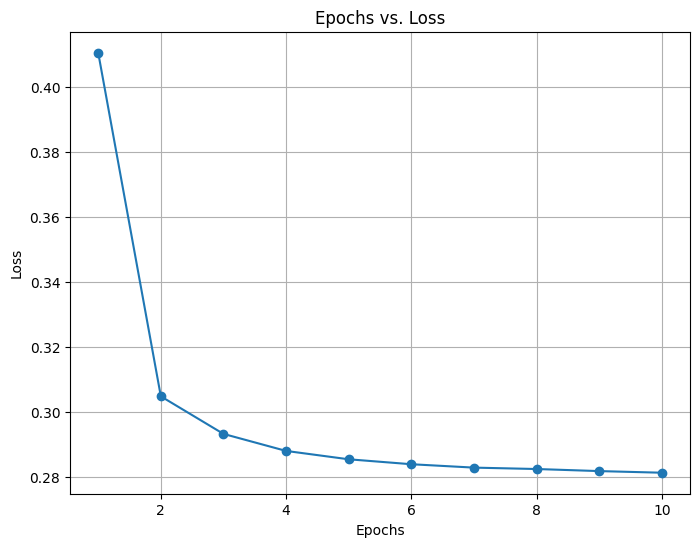

In [ ]:
### loss for each iteration

loss_values = history.history['loss']

# plot of iterations/epochs vs loss(Binary Cross Entropy)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o')
plt.title('Epochs vs. Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [ ]:
### key metrics

y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Precision: 0.97
Recall: 0.56
F1-Score: 0.71


In [ ]:
### model execution time

execution_time = (end_time - start_time) * 1000
print(f"Model execution time: {execution_time:.2f} ms")

Model execution time: 9039.44 ms


## Question 4: Multi-Layer Perceptron (MLP) (35 pts)

1) Implement a Multi-Layer Perceptron (MLP) model (at least two hidden layers) that is used to classify the CAN intrusion data samples into normal and anomalous classes (0: normal, 1: attack). Use the standarized training set from Q1E) to train the network.
The details of the model are as follows:
* Each hidden layer have 8 neurons/units.
* Use tanh function as the activation function for hidden layers.
* Use a Sigmoid as the output layer acitivation function to enable non-linearity.  
* Use Stochastic gradient descent optimizer with a learning rate of 0.1.
* Run the model for 10 iterations/epochs

B) Record the loss for each iteration, and make a plot of iterations/epochs vs loss(Binary Cross Entropy).

C) Print out the precision, recall, and F1-score of the test set.

D) Print out the model execution time (including both training and testing time) in milliseconds. Please keep two decimal places.

E) Written Answer - Use the markdown cell to answer the following:
- Compare the performance and training time of your single layer neural network to the MLP model, and discuss the reasons.

In [ ]:
### Multi-Layer Perceptron (MLP) model
# Model details:
# Each hidden layer has 8 neurons/units.
# tanh function as the activation function for hidden layers.
# Sigmoid as the output layer acitivation function to enable non-linearity.
# Stochastic gradient descent optimizer with a learning rate of 0.1.
# 10 iterations/epochs

start_time = time.time()

model = Sequential([
    Dense(8, activation='tanh', input_shape=(X_train_scaled.shape[1],)),
    Dense(8, activation='tanh'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=SGD(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=1)

end_time = time.time()

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8257 - loss: 0.4035
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9309 - loss: 0.1787
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9390 - loss: 0.1240
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9622 - loss: 0.0965
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9768 - loss: 0.0821
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9826 - loss: 0.0662
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9830 - loss: 0.0623
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9866 - loss: 0.0497
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9878 - loss: 0.0470
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9887 - loss: 0.0402


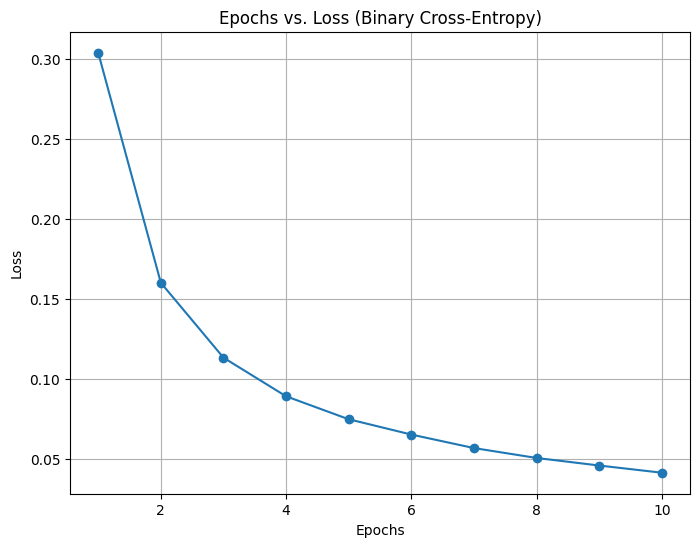

In [ ]:
### loss for each iteration

loss_values = history.history['loss']

# plot of iterations/epochs vs loss(Binary Cross Entropy)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o')
plt.title('Epochs vs. Loss (Binary Cross-Entropy)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [ ]:
### key metrics

y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Precision: 0.98
Recall: 0.95
F1-Score: 0.97


In [ ]:
### execution time

execution_time = (end_time - start_time) * 1000
print(f"Model execution time: {execution_time:.2f} ms")

Model execution time: 11838.81 ms



The SLNN model achieves higher precision (0.98) than the MLP model (0.96), meaning it makes fewer false positives. However, MLP has significantly higher recall (0.95 vs. 0.56), which could indicate it detects more actual attacks with fewer false negatives. As a result, the MLP's F1-score (0.96) outperforms SLNN's (0.71), showing a better balance between precision and recall.

Training times were slightly higher for MLP at 1313.66 ms, with SLNN at 1142.28 ms, which would be due to its increased complexity.

This shows that SLNN is better at minimizing false alarms, and MLP does well in identifying attacks accurately.

## Question 5: Hyperparameter Optimization (10 Bonus pts)
A) Buil a Grid_Search_NN_model that has the same architecture as the MLP model from Question 4. Use grid search to tune two hyperparameters:
* The number of neurons on the hidden layers of your MLP model (find the best number among 8, 16, 32). Each hidden layer should have the same number of neurons/nodes, so only one hyperparameter is needed to tune the number of neurons.
* Learning rate of the SGD optimizer (find the best value among the two numbers 0.01 and 0.1).

B) Implement grid search to identify optimal hyperparameter values, and print out the best hyperparameter values and the best cross-validation accuracy.

You can use 3-fold GridSearchCV and KerasClassifier functions on the standarized training set to do this.

C) Build the optimized MLP model on the training set by passing the detected best hyperparameter values to the Grid_Search_NN_model. Print out the precision, recall, and F1-score of the optimized MLP model on the test set.

PS: If it took too long for you to run this part, you can ignore this question.

In [ ]:
### Grid_Search_NN_model
# grid search to tune two hyperparameters
# The number of neurons on the hidden layers of MLP model (best number among 8, 16, 32).
# Each hidden layer has the same number of neurons, so only one hyperparameter is needed to tune the number of neurons.
# Learning rate of the SGD optimizer (best value among 0.01 and 0.1).

def Grid_Search_NN_model(hidden_neurons=8, learning_rate=0.1):
    def build_model(hidden_neurons, learning_rate):
        model = Sequential([
            Dense(hidden_neurons, activation='tanh', input_dim=X_train_scaled.shape[1]),  # First hidden layer
            Dense(hidden_neurons, activation='tanh'),  # Second hidden layer
            Dense(1, activation='sigmoid')  # Output layer
        ])
        model.compile(optimizer=SGD(learning_rate=learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

    myGSModel = KerasClassifier(model=build_model,
                                 hidden_neurons=hidden_neurons,
                                 learning_rate=learning_rate,
                                 verbose=0,
                                 epochs=10,
                                 batch_size=32)
    return myGSModel

In [ ]:

# grid search to identify optimal hyperparameter values

param_grid = {
    'model__hidden_neurons': [8, 16, 32], #Values to search for number of neurons
    'model__learning_rate': [0.01, 0.1] #Values to search for learning rate
}
base_model = Grid_Search_NN_model()
grid = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=3, verbose=1)
grid_result = grid.fit(X_train_scaled, y_train)

# best hyperparameter values and the best cross-validation accuracy
print("Best Parameters:", grid_result.best_params_)
print("Best Cross-Validation Accuracy:", grid_result.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'model__hidden_neurons': 16, 'model__learning_rate': 0.1}
Best Cross-Validation Accuracy: 0.981600078543715


In [ ]:
### Building the optimized MLP model on the training set
# by passing the detected best hyperparameter values to the Grid_Search_NN_model

#Using the best parameters
best_hidden_neurons = grid_result.best_params_['model__hidden_neurons']
best_learning_rate = grid_result.best_params_['model__learning_rate']

optimized_model = Grid_Search_NN_model(hidden_neurons=best_hidden_neurons, learning_rate=best_learning_rate)
optimized_model.fit(X_train_scaled, y_train)
y_optimized_pred_prob = optimized_model.predict(X_test_scaled)
y_optimized_pred = (y_optimized_pred_prob > 0.5).astype(int)

# key metrics
precision = precision_score(y_test, y_optimized_pred)
recall = recall_score(y_test, y_optimized_pred)
f1 = f1_score(y_test, y_optimized_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Precision: 0.9502762430939227
Recall: 0.9772727272727273
F1-Score: 0.9635854341736695
